# Tuning Parameter Initiation (zeros vs. random vs. Xavier)

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
# import h5py
import sklearn.datasets
%matplotlib inline

---
## Loading dummy data

In [2]:
def load_dataset():
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
    
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    
    return train_X, train_Y, test_X, test_Y

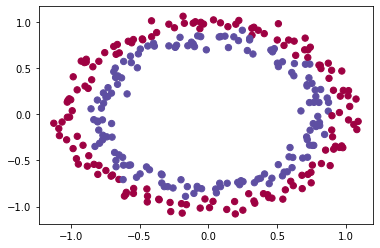

In [3]:
X_train, Y_train, X_test, Y_test = load_dataset()

In [4]:
print(np.unique(Y_train)), print(X_train.shape, Y_train.shape)

[0 1]
(2, 300) (1, 300)


(None, None)

---
# Tuning

## Initialize Parameters - different methods

In [5]:
def initialize_parameters(layer_dims, init_type = 'zeros'):
    np.random.seed(3)
    params = {}
    L = len(layer_dims)
    
    # skip input/ layer 0
    for i in range(1,L):
        if init_type == 'zeros':
            params["W" + str(i)] = np.zeros((layer_dims[i], layer_dims[i-1]))
            params["b" + str(i)] = np.zeros((layer_dims[i], 1))
        
        elif init_type == 'random':
            params["W" + str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1])*10  #scaled to a large value
            params["b" + str(i)] = np.zeros((layer_dims[i], 1))

        elif init_type == 'xavier':
            params["W" + str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) * np.sqrt(2/layer_dims[i-1])
            params["b" + str(i)] = np.zeros((layer_dims[i], 1))

    return params

---
### Forward Propagation

In [6]:
def linear_activation_forward(A_prev, W, b, activation='relu'):
    """ Compute forward propagation across one layer """
    
    Z = np.dot(W, A_prev) + b
    
    if activation == "sigmoid":    
        A = 1/(1+np.exp(-Z))
    elif activation == "relu":
        A = np.maximum(0, Z)
    
    cache_in  = (A_prev, W, b)   # Note the definition, cache_in = inputs
    cache = (cache_in, Z)        # Note the definition, cache = inputs + output

    return A, cache

In [7]:
def forward_propagation(X, parameters):
    """ Compute forward propagation across layers """
    
    caches = []
    A = X
    L = len(parameters) // 2 # number of layers in the neural network
    
    # Layers: 1, 2, .. L-1
    for l in range(1, L):  
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], 'relu')
        caches.append(cache)
            
    # Final layer
    AL, cache = linear_activation_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], 'sigmoid') 
    
    # ((A_prev, W, b), Z)
    caches.append(cache)
          
    return AL, caches

### Cost

In [8]:
def compute_cost(AL, Y):
    """ Computes the cross-entropy cost """
    
    m = Y.shape[1]   # number of examples
    logprobs = np.multiply(-np.log(AL),Y) + np.multiply(-np.log(1 - AL), 1 - Y)
    cost = 1./m * np.nansum(logprobs)
    
#     cost = (-1/m)*(np.dot(np.log(AL), Y.T) + np.dot(np.log(1-AL), (1-Y).T))    
#     cost = float(np.squeeze(cost))
    return cost

### Backward Propagation

In [9]:
def linear_activation_backward(dA, cache, activation, Y=None):
    """ Compute backward propagation across one layer """

    (A_prev, W, b), Z = cache
    
    # Calculate dZ
    if activation == "relu":
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        
    elif activation == "sigmoid": # <--- simplify dA x s x (1-s), where s=AL to, s - Y
        s = 1/(1+np.exp(-Z))
        dZ = s - Y                # <--- simplified  dA * s * (1-s)
    
    # Gradients
    m = A_prev.shape[1]
    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
        
    return dA_prev, dW, db

In [10]:
def backward_propagation(AL, Y, caches):
    """ Compute backward propagation across across layer """
    
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # Y is the same shape as AL
    
    # Last layer
    dAL = np.zeros(Y.shape)   
           #- (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))  # throws divide by 0 error <-- simplify
    
    # Lth layer (SIGMOID -> LINEAR) gradients
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, 'sigmoid', Y) # <-- simplify
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_prev_temp, current_cache, 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp
        
    return grads

### Update Parameters

In [11]:
def update_parameters(parameters, grads, learning_rate=0.01):
    """
    Updates parameters using the gradient descent
    """
    params = parameters.copy()
    L = len(params) // 2 # number of layers in the neural network

    for l in range(L):
        params["W" + str(l+1)] = params["W" + str(l+1)] - learning_rate*grads['dW'+str(l+1)]
        params["b" + str(l+1)] = params["b" + str(l+1)] - learning_rate*grads['db'+str(l+1)]
    
    return params

### Predict

In [12]:
def predict(parameters, X):
    AL, _ = forward_propagation(X, parameters)
    predictions = np.round(AL)
    return predictions

### Combining into an Overall Model

In [13]:
def multi_layer_model(X_train, Y_train, X_test, Y_test, layer_dims, init_type = 'random',
                      num_iterations = 3000, print_cost=True, learning_rate=0.001):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Structure:
    - initialize parameters using 'init_type' (random, xavier, zeros) initialization
    - Iterate over {forward propagation / AL, cost, backward propagation/ gradients, update parameters}
    """
#     grads = {} 
    costs = []
    m = X_train.shape[1]  # number of examples
    layer_dims = [X_train.shape[0]] + layer_dims
    parameters = initialize_parameters(layer_dims, init_type)
    
    for i in range(num_iterations):
    
        AL, caches = forward_propagation(X_train, parameters)             # Forward pass to get AL and caches
        cost = compute_cost(AL, Y_train)                                  # Compute cost
        grads = backward_propagation(AL, Y_train, caches)                 # Backward pass to get gradients
        parameters = update_parameters(parameters, grads, learning_rate)  # Update params
        
        if print_cost and (i % 1000 == 0 or i == num_iterations-1):
            print ('Cost after iteration {}: {:.4f}'.format(i, cost))
            costs.append(cost)

    # Make Predictions
    Y_pred_train = predict(parameters, X_train)
    Y_pred_test = predict(parameters, X_test)
    
    # Print train/test fit
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_test - Y_test)) * 100))
    
    # Save model output
    d = {"costs": costs,
         "Y_pred_train": Y_pred_train, 
         "Y_pred_test" : Y_pred_test, 
         "parameters" : parameters,
         "learning_rate" : learning_rate}
    
    # Plot the loss
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return d

---
## Running Model

In [14]:
layer_dims = [10, 5, 1] 

Cost after iteration 0: 0.6931
Cost after iteration 1000: 0.6931
Cost after iteration 2000: 0.6931
Cost after iteration 3000: 0.6931
Cost after iteration 4000: 0.6931
Cost after iteration 5000: 0.6931
Cost after iteration 6000: 0.6931
Cost after iteration 7000: 0.6931
Cost after iteration 8000: 0.6931
Cost after iteration 9000: 0.6931
Cost after iteration 10000: 0.6931
Cost after iteration 11000: 0.6931
Cost after iteration 12000: 0.6931
Cost after iteration 13000: 0.6931
Cost after iteration 14000: 0.6931
Cost after iteration 14999: 0.6931
train accuracy: 50.0 %
test accuracy: 50.0 %


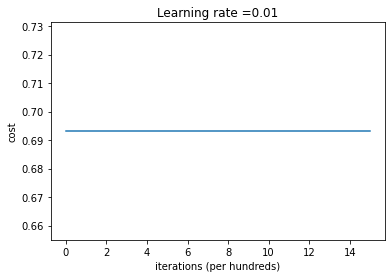

In [15]:
model0 = multi_layer_model(X_train, Y_train, X_test, Y_test, layer_dims, init_type='zeros',
                          num_iterations = 15000, print_cost=True, learning_rate=0.01)

In [16]:
def predict_dec(parameters, X):
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    return predictions

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

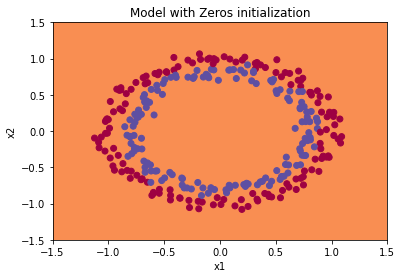

In [17]:
plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(model0['parameters'], x.T), X_train, Y_train)

C:\Users\uditg\AppData\Local\Temp\ipykernel_22252\895399303.py:5: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(AL),Y) + np.multiply(-np.log(1 - AL), 1 - Y)
C:\Users\uditg\AppData\Local\Temp\ipykernel_22252\895399303.py:5: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(AL),Y) + np.multiply(-np.log(1 - AL), 1 - Y)


Cost after iteration 0: inf
Cost after iteration 1000: 0.6238
Cost after iteration 2000: 0.5978
Cost after iteration 3000: 0.5636
Cost after iteration 4000: 0.5501
Cost after iteration 5000: 0.5443
Cost after iteration 6000: 0.5374
Cost after iteration 7000: 0.4694
Cost after iteration 8000: 0.3977
Cost after iteration 9000: 0.3934
Cost after iteration 10000: 0.3920
Cost after iteration 11000: 0.3891
Cost after iteration 12000: 0.3861
Cost after iteration 13000: 0.3850
Cost after iteration 14000: 0.3827
Cost after iteration 14999: 0.3810
train accuracy: 83.0 %
test accuracy: 86.0 %


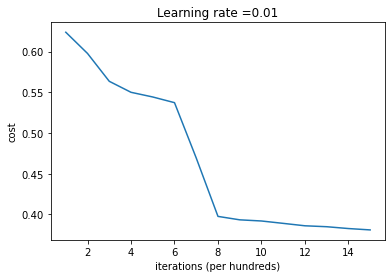

In [18]:
model1 = multi_layer_model(X_train, Y_train, X_test, Y_test, layer_dims, init_type='random',
                          num_iterations = 15000, print_cost=True, learning_rate=0.01)

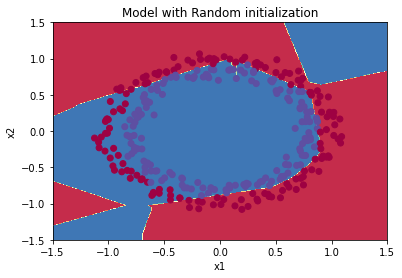

In [19]:
plt.title("Model with Random initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(model1['parameters'], x.T), X_train, Y_train)

Cost after iteration 0: 0.8831
Cost after iteration 1000: 0.6880
Cost after iteration 2000: 0.6751
Cost after iteration 3000: 0.6526
Cost after iteration 4000: 0.6083
Cost after iteration 5000: 0.5305
Cost after iteration 6000: 0.4139
Cost after iteration 7000: 0.3118
Cost after iteration 8000: 0.2370
Cost after iteration 9000: 0.1860
Cost after iteration 10000: 0.1502
Cost after iteration 11000: 0.1233
Cost after iteration 12000: 0.0992
Cost after iteration 13000: 0.0846
Cost after iteration 14000: 0.0736
Cost after iteration 14999: 0.0648
train accuracy: 99.33333333333333 %
test accuracy: 96.0 %


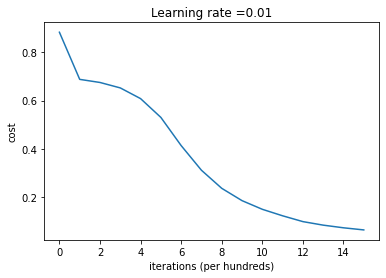

In [20]:
model2 = multi_layer_model(X_train, Y_train, X_test, Y_test, layer_dims, init_type='xavier',
                          num_iterations = 15000, print_cost=True, learning_rate=0.01)

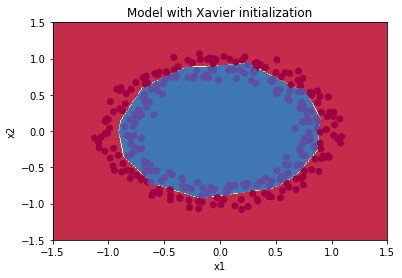

In [21]:
plt.title("Model with Xavier initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(model2['parameters'], x.T), X_train, Y_train)

<font color='blue'>
    
**To remember**:
- The weights $W^{[l]}$ should be initialized randomly to break symmetry. 
- However, it's okay to initialize the biases $b^{[l]}$ to zeros. Symmetry is still broken so long as $W^{[l]}$ is initialized randomly. 
    
For the same number of iterations and same hyperparameters, the comparison is:

<table> 
    <tr>
        <td>
            <b>Model</b>
        </td>
        <td>
            <b>Train accuracy</b>
        </td>
        <td>
            <b>Problem/Comment</b>
        </td>
    </tr>
        <td>
        3-layer NN with zeros initialization
        </td>
        <td>
        50%
        </td>
        <td>
        fails to break symmetry
        </td>
    <tr>
        <td>
        3-layer NN with large random initialization
        </td>
        <td>
        83%
        </td>
        <td>
        too large weights 
        </td>
    </tr>
    <tr>
        <td>
        3-layer NN with He initialization
        </td>
        <td>
        99%
        </td>
        <td>
        recommended method
        </td>
    </tr>
</table> 